<a href="https://colab.research.google.com/github/daviethedeveloper/TensorFlowNotes/blob/main/05_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with 2. Fine tuning

In [ ]:
# Check if using GPU
!nvidia-smi

Tue Jul 11 18:42:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Created helper functions

These Helper Functions are able to use again from a script imported from notebooks

Functions used previosly

link: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-13 01:34:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-13 01:34:44 (90.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note** If running the notebook (google collab runtime timesout) will delete the helper functions, redownload the access to the helper functions

## Getting the data

Going to use the pretrained models within `tf.keras.applications` and apply them to my own problem, recognizing images of food.

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [12]:
# Get only 10% of the training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-07-13 01:45:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  14.1MB/s    in 11s     

2023-07-13 01:45:56 (14.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectoriea are in the dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# Creating training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Import Packages
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                      image_size=IMG_SIZE,
                                                                      label_mode="categorical",
                                                                      batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of the dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[167.71428   187.71428   186.71428  ]
   [168.9796    188.9796    187.9796   ]
   [166.9949    186.9949    185.9949   ]
   ...
   [173.29079   196.648     198.86226  ]
   [170.97449   194.97449   196.97449  ]
   [171.35718   195.35718   197.35718  ]]

  [[165.        185.        184.       ]
   [166.        186.        185.       ]
   [167.14285   187.14285   186.14285  ]
   ...
   [171.301     194.6582    196.87247  ]
   [170.07143   194.07143   196.07143  ]
   [171.35718   195.35718   197.35718  ]]

  [[166.63776   186.63776   185.63776  ]
   [163.12755   183.12755   182.12755  ]
   [163.30612   183.30612   182.30612  ]
   ...
   [171.2602    194.6174    196.83167  ]
   [171.42857   195.42857   197.42857  ]
   [173.78575   197.78575   199.78575  ]]

  ...

  [[157.45413    29.224169   49.162952 ]
   [176.90744    85.54449   104.23338  ]
   [212.15355   175.16818   191.73468  ]
   ...
   [ 99.35199    15.367578   22.683788 ]
   [113.92923    66.89916    61.64383  ]
   [1

## Model 0: Building a transfer learning model using the keras Funcional API

* The functional API is more flexible
* Start small model (baseline) then build larger

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model ( so the underlying pre=trained patterns aren't updated during training )
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. Optional a model like ResNet50V2 be precise normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the ouputs of the base model (aggregate the most iportant information)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a mode
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230711-194649
Epoch 1/5
24/24 [==============================] - 23s 281ms/step - loss: 1.9374 - accuracy: 0.3880 - val_loss: 1.3581 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 5s 182ms/step - loss: 1.1309 - accuracy: 0.7467 - val_loss: 0.8838 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 5s 188ms/step - loss: 0.7917 - accuracy: 0.8067 - val_loss: 0.7020 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 5s 165ms/step - loss: 0.6448 - accuracy: 0.8507 - val_loss: 0.6351 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 5s 179ms/step - loss: 0.5441 - accuracy: 0.8720 - val_loss: 0.5535 - val_accuracy: 0.8651


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.5592 - accuracy: 0.8620


[0.5591506361961365, 0.8619999885559082]

In [ ]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [ ]:
# Summmary of the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


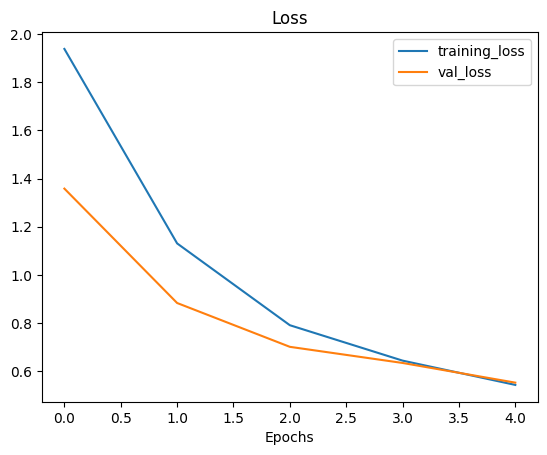

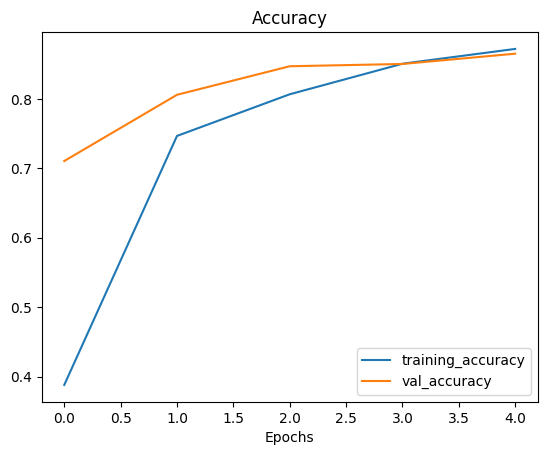

In [ ]:
# Check ou the models training curves
plot_loss_curves(history=history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

Tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then passes through GlobalAveragePooling2D, it turns into (None, 1280)

What does GlobalAveragePooling2D() do?

In [ ]:
# Define a input shape
input_shape = (1, 4, 4, 3)

# Set seed
tf.random.set_seed(42)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")


# Pass the random tensor through a global average 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# See the shapes
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D: (1, 3)


In [ ]:
# Replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

> Seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data....
* Set up experiments to check that:
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` use feature extraction transfer learning with 10% of the trainging with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

>**Note** throughout all the experiments the same test dataset will be used to evaluate the models (ensures consistency across evaluation metrics).

## Getting and preprocessing data for `model_1`

In [ ]:
# Downlaod and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-07-11 20:59:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  39.7MB/s    in 3.7s    

2023-07-11 20:59:04 (34.5 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
# Unzip the data
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
# Create training and test dir
train_dir_1 = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into the models, use:
* `tf.keras.layers.experimental.preprocessing()`

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create data augmentation stage with horizontal, flipping, rotations, zooms...etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 not for efficent model
], name="data_augmentation")

### Visualize the data augmentation layer (see what happens to the data)



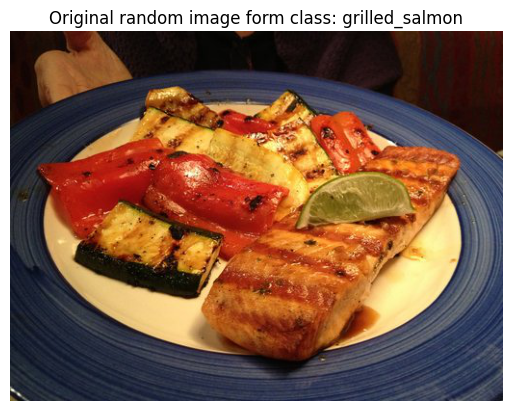

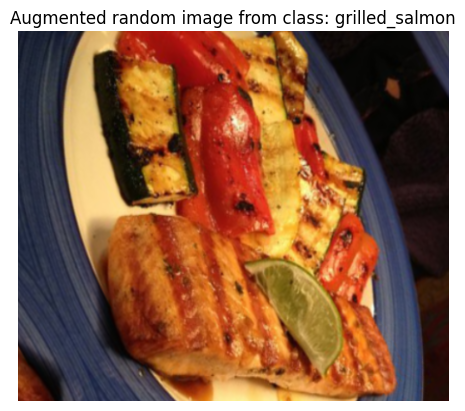

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image form class: {target_class}")
plt.axis(False);

# Now going to augment the random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow((augmented_img/255.))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% training data only

> With Data Augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)


# Make a model using the inputs and outputs
model_1  = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230711-215605
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.4722 - accuracy: 0.1000 - val_loss: 2.3239 - val_accuracy: 0.1398
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2179 - accuracy: 0.2143 - val_loss: 2.1780 - val_accuracy: 0.2188
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9965 - accuracy: 0.3571 - val_loss: 2.0686 - val_accuracy: 0.2911
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8005 - accuracy: 0.4714 - val_loss: 1.9575 - val_accuracy: 0.3799
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6293 - accuracy: 0.6286 - val_loss: 1.8491 - val_accuracy: 0.4671


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 86ms/step - loss: 1.8395 - accuracy: 0.4656


[1.8394805192947388, 0.46560001373291016]

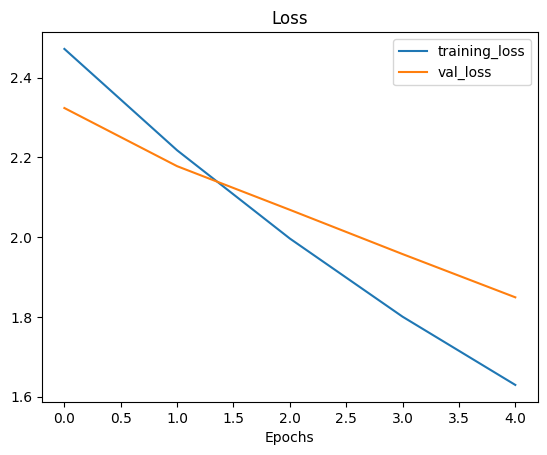

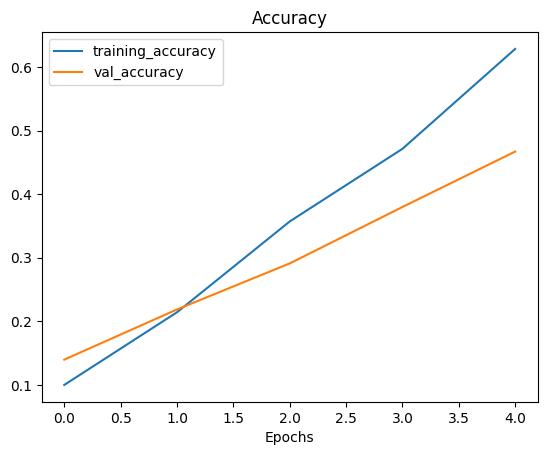

In [ ]:
# How do the model with 1% of the data and augmentation loss curves look like?
plot_loss_curves(history=history_1_percent)

## Model 2: Feature extraction transfer learning model woth 10% of the data

In [9]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [10]:
# Check the images in directores
walk_through_dir("10_food_classes_10_percent")

In [13]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [14]:
# Create Model 2 with data augmenttion built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

# Setup the input shape to the mode
input_shape = (224, 224, 3)

# Create a frozen base model (also a backbone) ResNet50 as the backbone
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Creat the inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment the training images (doesn't on test images)
x = base_model(x, training = False) # pass the augmented to the base model, but keep the base model in inference mode
x = layers.GlobalAveragePooling2D(name="global_avergae_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


16705208/16705208 [==============================] - 2s 0us/step


In [16]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avergae_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### Creating a ModelCheckpoint
>**Note**: Callbacks are a tool which can add helpful functionality to the models during training, evaluation or inference

> Popular ones:
* TensorBoard `tf.keras.callbacks.TensorBoard()`
* Model checkpointing  `tf.keras.callbacks.ModelCheckpoint()`
* Early Stopping  `tf.keras.callbacks.EarlyStopping()`

> ModelChekpoint callback intermediately saves the model (just the weights) during training. This is useful to go and start where left off.


In [15]:
# Set Checkpoint Path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saved the model...weight only
# Saves the model quicker
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", # save every epoch,
                                                         verbose=1)

### Fit Model 2 passing in the ModelCheckpoint callback

In [16]:
# Fit the model saving checkpoints every epoch
intial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=intial_epochs,
                                          validation_data = test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aig"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aig/20230713-014712
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0611 - accuracy: 0.3040
Epoch 1: val_loss improved from inf to 1.48449, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 34s 763ms/step - loss: 2.0611 - accuracy: 0.3040 - val_loss: 1.4845 - val_accuracy: 0.6562
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3629 - accuracy: 0.6707
Epoch 2: val_loss improved from 1.48449 to 1.03378, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 573ms/step - loss: 1.3629 - accuracy: 0.6707 - val_loss: 1.0338 - val_accuracy: 0.7697
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.7640
Epoch 3: val_loss improved from 1.03378 to 0.82451, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [17]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6317 - accuracy: 0.8444


[0.6316547393798828, 0.8443999886512756]

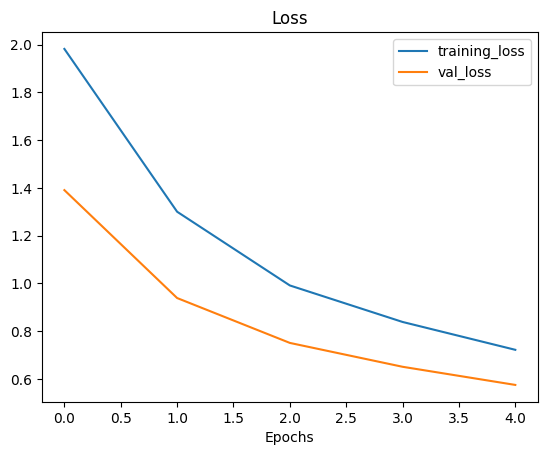

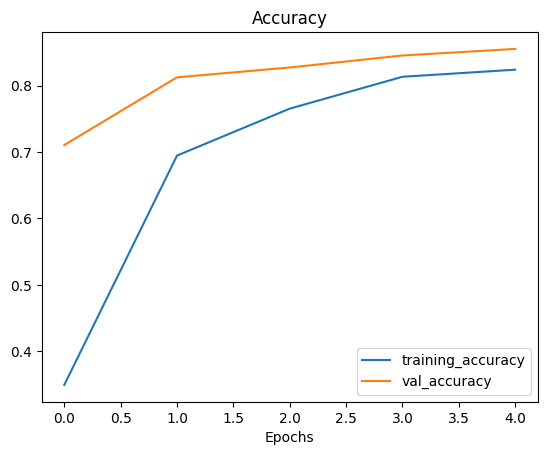

In [26]:
# Plot Loss Curve
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
>**Note** Loading in checkpointed weights returns a model to a specific checkpoint.

In [27]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [28]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 10s 120ms/step - loss: 0.6092 - accuracy: 0.8428


## Model3: Fine-tunning an existing model on 10% of the data

>**Note**: Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of a custom data...
* 1. Build the feature extraction model first
* 2. Then unfreeze some of the underlying layers

In [30]:
# layers in loaded model
model_2.layers

In [31]:
# Are the layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7e46bf81d2a0> True
<keras.engine.sequential.Sequential object at 0x7e46bf1a70d0> True
<keras.engine.functional.Functional object at 0x7e46bed7f5b0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e46beca83a0> True
<keras.layers.core.dense.Dense object at 0x7e46bed7fc10> True


In [33]:
# What layers are in the model - EfficientNetB0 are they trainable??
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [36]:
# How many trainable variables are in the base model?
print(len(model_2.layers[2].trainable_variables))

0


In [37]:
# Import base model, trainable set to False when creating...all the layers to false
#  Results in zero trainable layers How to make the top 10 layers trainable?? Set them all
#   to True, except for the last 10

In [18]:
# Begin Fine-tuning, start by setting the last 10 layers of the base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Change a parameter need to recompile the models every time create a change
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # fine-tuning less from 10x
                metrics=["accuracy"])

> **Note**: When using fine-tuning best practice to lower learning rate by some amount, Good rule of thumb, at least 10x

In [19]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [20]:
# Now some of the layers are unfrozen, trainable layers are there
print(len(model_2.trainable_variables))

12


In [21]:
# Fine tune for another 5 epochs
fine_tune_epochs = intial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 *len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                     experiment_name="10_percent_fine_tune_last_10")])



Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230713-014947
Epoch 5/10
24/24 [==============================] - 26s 589ms/step - loss: 0.6379 - accuracy: 0.8120 - val_loss: 0.5280 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - 11s 432ms/step - loss: 0.5030 - accuracy: 0.8480 - val_loss: 0.4442 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 10s 408ms/step - loss: 0.4269 - accuracy: 0.8693 - val_loss: 0.4500 - val_accuracy: 0.8602
Epoch 8/10
24/24 [==============================] - 11s 459ms/step - loss: 0.4070 - accuracy: 0.8867 - val_loss: 0.4454 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 15s 592ms/step - loss: 0.3569 - accuracy: 0.8987 - val_loss: 0.4632 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 14s 576ms/step - loss: 0.3224 - accuracy: 0.9027 - val_loss: 0.4339 - val_accuracy: 0.8668


In [22]:
# Evaluate the fine-tune model (model_3 which is model_2 fine-tines for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.4151 - accuracy: 0.8604


## Model 4: Fine-tuning and existing model on all of the data

In [4]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-07-13 01:35:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.2MB/s    in 24s     

2023-07-13 01:35:44 (21.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [5]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [7]:
# How many images working with?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset loaded in is the same as used on the previous experiments

In [23]:
# Evaluate model 2 (this is the fine-tunes on 10 percent data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.4151 - accuracy: 0.8604


[0.41513803601264954, 0.8604000210762024]

To train a fine-tuning model (model_4) need to revert model_2 back to its feature extraction weights

>**Note** Load weights from checkpoint